<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/master/C3/W4/ungraded_labs/C3_W4_Lab_2_irish_lyrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Generating Text from Irish Lyrics

In the previous lab, you trained a model on just a single song. You might have found that the output text can quickly become gibberish or repetitive. Even if you tweak the hyperparameters, the model will still be limited by its vocabulary of only 263 words. The model will be more flexible if you train it on a much larger corpus and that's what you'll be doing in this lab. You will use lyrics from more Irish songs then see how the generated text looks like. You will also see how this impacts the process from data preparation to model training. Let's get started!

## Imports

In [1]:
import tensorflow as tf
import numpy as np 

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

## Building the Word Vocabulary

You will first download the lyrics dataset. These will be from a compilation of traditional Irish songs and you can see them [here](https://github.com/https-deeplearning-ai/tensorflow-1-public/blob/main/C3/W4/misc/Laurences_generated_poetry.txt). 

In [2]:
# Download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course3/irish-lyrics-eof.txt

--2022-08-31 20:09:35--  https://storage.googleapis.com/tensorflow-1-public/course3/irish-lyrics-eof.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.72.80, 142.250.72.48, 142.250.69.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.72.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68970 (67K) [text/plain]
Saving to: ‘irish-lyrics-eof.txt’

irish-lyrics-eof.tx 100%[===================>]  67.35K  --.-KB/s    in 0.01s   

2022-08-31 20:09:36 (4.48 MB/s) - ‘irish-lyrics-eof.txt’ saved [68970/68970]



Next, you will lowercase and split the plain text into a list of sentences:

In [ ]:
# Load the dataset
data = open('./irish-lyrics-eof.txt').read()

# Lowercase and split the text
corpus = data.lower().split("\n")

# Preview the result
print(corpus)

From here, you can initialize the `Tokenizer` class and generate the word index dictionary:

In [ ]:
# Initialize the Tokenizer class
tokenizer = Tokenizer()

# Generate the word index dictionary
tokenizer.fit_on_texts(corpus)

# Define the total words. You add 1 for the index `0` which is just the padding token.
total_words = len(tokenizer.word_index) + 1

print(f'word index dictionary: {tokenizer.word_index}')
print(f'total words: {total_words}')

## Preprocessing the Dataset

Next, you will generate the inputs and labels for your model. The process will be identical to the previous lab. The `xs` or inputs to the model will be padded sequences, while the `ys` or labels are one-hot encoded arrays.

In [5]:
# Initialize the sequences list
input_sequences = []

# Loop over every line
for line in corpus:

	# Tokenize the current line
	token_list = tokenizer.texts_to_sequences([line])[0]

	# Loop over the line several times to generate the subphrases
	for i in range(1, len(token_list)):
		
		# Generate the subphrase
		n_gram_sequence = token_list[:i+1]

		# Append the subphrase to the sequences list
		input_sequences.append(n_gram_sequence)

# Get the length of the longest line
max_sequence_len = max([len(x) for x in input_sequences])

# Pad all sequences
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# Create inputs and label by splitting the last token in the subphrases
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]

# Convert the label into one-hot arrays
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

You can then print some of the examples as a sanity check.

In [6]:
# Get sample sentence
sentence = corpus[0].split()
print(f'sample sentence: {sentence}')

# Initialize token list
token_list = []

# Look up the indices of each word and append to the list
for word in sentence: 
  token_list.append(tokenizer.word_index[word])

# Print the token list
print(token_list)

sample sentence: ['come', 'all', 'ye', 'maidens', 'young', 'and', 'fair']
[51, 12, 96, 1217, 48, 2, 69]


In [7]:
# Pick element
elem_number = 5

# Print token list and phrase
print(f'token list: {xs[elem_number]}')
print(f'decoded to text: {tokenizer.sequences_to_texts([xs[elem_number]])}')

# Print label
print(f'one-hot label: {ys[elem_number]}')
print(f'index of label: {np.argmax(ys[elem_number])}')

token list: [   0    0    0    0    0    0    0    0    0   51   12   96 1217   48
    2]
decoded to text: ['come all ye maidens young and']
one-hot label: [0. 0. 0. ... 0. 0. 0.]
index of label: 69


In [8]:
# Pick element
elem_number = 4

# Print token list and phrase
print(f'token list: {xs[elem_number]}')
print(f'decoded to text: {tokenizer.sequences_to_texts([xs[elem_number]])}')

# Print label
print(f'one-hot label: {ys[elem_number]}')
print(f'index of label: {np.argmax(ys[elem_number])}')

token list: [   0    0    0    0    0    0    0    0    0    0   51   12   96 1217
   48]
decoded to text: ['come all ye maidens young']
one-hot label: [0. 0. 1. ... 0. 0. 0.]
index of label: 2


## Build and compile the Model

Next, you will build and compile the model. We placed some of the hyperparameters at the top of the code cell so you can easily tweak it later if you want.

In [9]:
# Hyperparameters
embedding_dim = 100
lstm_units = 150
learning_rate = 0.01

# Build the model
model = Sequential([
          Embedding(total_words, embedding_dim, input_length=max_sequence_len-1),
          Bidirectional(LSTM(lstm_units)),
          Dense(total_words, activation='softmax')
])

# Use categorical crossentropy because this is a multi-class problem
model.compile(
    loss='categorical_crossentropy', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
    metrics=['accuracy']
    )

# Print the model summary
model.summary()

2022-08-31 20:11:31.612525: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-31 20:11:31.639206: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-31 20:11:31.639371: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-31 20:11:31.640239: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 100)           269000    
                                                                 
 bidirectional (Bidirectiona  (None, 300)              301200    
 l)                                                              
                                                                 
 dense (Dense)               (None, 2690)              809690    
                                                                 
Total params: 1,379,890
Trainable params: 1,379,890
Non-trainable params: 0
_________________________________________________________________


## Train the model

From the model summary above, you'll notice that the number of trainable params is much larger than the one in the previous lab. Consequently, that usually means a slower training time. It will take roughly 7 seconds per epoch with the GPU enabled in Colab and you'll reach around 76% accuracy after 100 epochs.

In [10]:
epochs = 100

# Train the model
history = model.fit(xs, ys, epochs=epochs)

Epoch 1/100
 11/377 [..............................] - ETA: 1s - loss: 7.3348 - accuracy: 0.0284       

2022-08-31 20:11:47.414690: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8500


377/377 [==============================] - 4s 5ms/step - loss: 6.6340 - accuracy: 0.0743
Epoch 2/100
377/377 [==============================] - 2s 5ms/step - loss: 5.7679 - accuracy: 0.1147
Epoch 3/100
377/377 [==============================] - 2s 5ms/step - loss: 4.9025 - accuracy: 0.1663
Epoch 4/100
377/377 [==============================] - 2s 5ms/step - loss: 3.9352 - accuracy: 0.2385
Epoch 5/100
377/377 [==============================] - 2s 5ms/step - loss: 3.0927 - accuracy: 0.3444
Epoch 6/100
377/377 [==============================] - 2s 5ms/step - loss: 2.4268 - accuracy: 0.4523
Epoch 7/100
377/377 [==============================] - 2s 5ms/step - loss: 1.8872 - accuracy: 0.5626
Epoch 8/100
377/377 [==============================] - 2s 5ms/step - loss: 1.5362 - accuracy: 0.6341
Epoch 9/100
377/377 [==============================] - 2s 5ms/step - loss: 1.2993 - accuracy: 0.6842
Epoch 10/100
377/377 [==============================] - 2s 5ms/step - loss: 1.1671 - accuracy: 0.7170
E

You can visualize the accuracy below to see how it fluctuates as the training progresses.

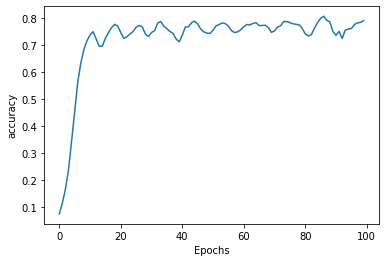

In [11]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

# Visualize the accuracy
plot_graphs(history, 'accuracy')

## Generating Text

Now you can let the model make its own songs or poetry! Because it is trained on a much larger corpus, the results below should contain less repetitions as before. The code below picks the next word based on the highest probability output.

In [12]:
# Define seed text
seed_text = "help me obi-wan kinobi youre my only hope"

# Define total words to predict
next_words = 100

# Loop until desired length is reached
for _ in range(next_words):

	# Convert the seed text to a token sequence
	token_list = tokenizer.texts_to_sequences([seed_text])[0]

	# Pad the sequence
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	
	# Feed to the model and get the probabilities for each index
	probabilities = model.predict(token_list)

	# Get the index with the highest probability
	predicted = np.argmax(probabilities, axis=-1)[0]

	# Ignore if index is 0 because that is just the padding.
	if predicted != 0:
		
		# Look up the word associated with the index. 
		output_word = tokenizer.index_word[predicted]

		# Combine with the seed text
		seed_text += " " + output_word

# Print the result	
print(seed_text)

help me obi-wan kinobi youre my only hope and green were brave are they your friend gone gone gone gone gone your eyes hush love love i love gone love be eyes and town i town love gone away from town gone love eyes tree my love gone she right till my love love writin love gone gone gone i love eyes i gone away gone white eyes any lily man i could i love love gone among mad at i love gone she right gone gone among i right my keeping get love gone gone then i love best with sinking eyes gone alas gone or left


Here again is the code that gets the top 3 predictions and picks one at random.

In [13]:
# Define seed text
seed_text = "help me obi-wan kinobi youre my only hope"

# Define total words to predict
next_words = 100

# Loop until desired length is reached
for _ in range(next_words):

	# Convert the seed text to a token sequence
  token_list = tokenizer.texts_to_sequences([seed_text])[0]

	# Pad the sequence
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	
	# Feed to the model and get the probabilities for each index
  probabilities = model.predict(token_list)

  # Pick a random number from [1,2,3]
  choice = np.random.choice([1,2,3])
	
  # Sort the probabilities in ascending order 
  # and get the random choice from the end of the array
  predicted = np.argsort(probabilities)[0][-choice]

	# Ignore if index is 0 because that is just the padding.
  if predicted != 0:
		
		# Look up the word associated with the index. 
	  output_word = tokenizer.index_word[predicted]

		# Combine with the seed text
	  seed_text += " " + output_word

# Print the result	
print(seed_text)

help me obi-wan kinobi youre my only hope to ireland faded boy are so strength i would goes at gone i love beggarman thy eyes your eyes gone i love gone love someone i safely gone and year love love grew gone i roved then then eyes bridle town gone forbid went your goes high high i boy in this proud eyes glisten back to play the fine groves love love hands love gone love love gone love til da dying white i now seems eyes dirty took from town and odonnell eyes and bee jollity town tree hat right steal love your unseen clouded ever i sinking


## Wrap Up

This lab shows the effect of having a larger dataset to train your text generation model. As expected, this will take a longer time to prepare and train but the output will less likely become repetitive or gibberish. Try to tweak the hyperparameters and see if you get better results. You can also find some other text datasets and use it to train the model here.  